# Pumpkin Price Linear Regression

Linear regression is the simplest kind of model you can usefully build. So simple, in fact, that we're going to implement an example by hand in four lines of code!

In [1]:
import pandas as pd
nyc_pumpkins = pd.read_csv("../input/new-york_9-24-2016_9-30-2017.csv")
cat_map = {
    'sml': 0,
    'med': 1,
    'med-lge': 2,
    'lge': 3,
    'xlge': 4,
    'exjbo': 5
}
nyc_pumpkins = nyc_pumpkins.assign(
    size=nyc_pumpkins['Item Size'].map(cat_map),
    price=nyc_pumpkins['High Price'] + nyc_pumpkins['Low Price'] / 2,
    size_class=(nyc_pumpkins['Item Size'].map(cat_map) >= 2).astype(int)
)
nyc_pumpkins = nyc_pumpkins.drop([c for c in nyc_pumpkins.columns if c not in ['size', 'price', 'size_class']], 
                                 axis='columns')
nyc_pumpkins = nyc_pumpkins.dropna()

The following plot in `seaborn` shows that your regression isn't going to get you that far. There seems to be very little difference in price between size 3 and size 4 pumpkins, for example, which violates the linearity assumption of ordinary least squares.

We'll write a regressor anyway, though, because we're not interested in having a good model&mdash;I just want to demonstrate how easy it is to write a `scikit` style estimator by hand!

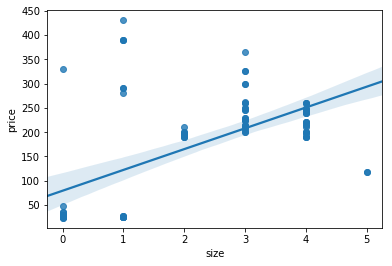

In [2]:
import seaborn as sns
sns.regplot('size', 'price', data=nyc_pumpkins)

To produce an ordinary least squares (OLS) solution for linear regression, you need to solve the matrix equation:

$$\hat{\beta} = (X^T X)^{-1}X^T y$$

The following tiny bit of code does just that:

In [3]:
import numpy as np

class LinearRegression:
    def fit(self, X, y):
        self.betas = np.linalg.inv(X.T @ X) @ X.T @ y
        
    def predict(self, X):
        return X @ self.betas

In [4]:
prices = nyc_pumpkins.values[:, :1]
sizes = nyc_pumpkins.values[:, 1:2]

clf = LinearRegression()
clf.fit(prices, sizes)
predicted_sizes = np.round(clf.predict(prices))

Here are our results:

In [5]:
outcome = pd.DataFrame(
    [sizes[:, 0], predicted_sizes[:, 0]]
).T.rename(columns={0: 'size', 1: 'predicted_size'})
outcome.head(10)

,size,predicted_size
0,4.0,3.0
1,3.0,3.0
2,4.0,2.0
3,3.0,2.0
4,2.0,2.0
5,4.0,3.0
6,3.0,3.0
7,1.0,3.0
8,4.0,3.0
9,3.0,3.0


Here are our resultant errors visualized in terms of how often we commit it in terms of absolute difference.

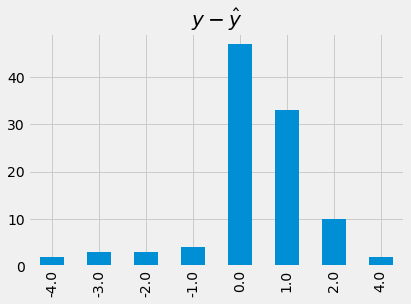

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

(outcome['size'] - outcome.predicted_size).value_counts().sort_index().plot.bar(
    title='$y - \hat{y}$'
)

Our little estimator commits a lot of error. But if we're satisfied with a result that's plus-minus one size category (these size categories are pretty arbitrary anyway; see Bouchard's kernel), then we're right 80% of the time. Which is still meh, but is probably OK for pumpkin-shopping purposes.

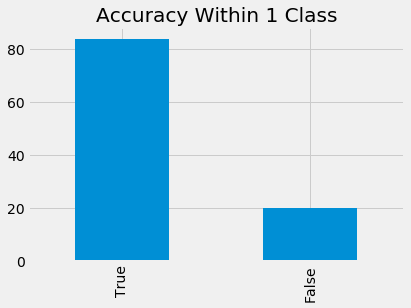

In [7]:
pd.Series(
    np.abs((outcome['size'] - outcome.predicted_size).values) <= 1
).value_counts().plot.bar(title='Accuracy Within 1 Class')